<a href="https://colab.research.google.com/github/ziatdinovmax/CSSAS-DML/blob/master/cssas_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate analysis

Notebook prepared by Maxim Ziatdinov (January 2020)


---
This notebook applies multivariate analysis to analyze time dynamics of the system of nanorods.


---




Imports:

In [0]:
import os
import numpy as np
import pandas as pd
from scipy import spatial
import cv2
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(Down)load the data. This may take 1-2 min.

In [0]:
download_link="https://drive.google.com/uc?id=1AydItNpicrbbnBJtd3iUbWeSt2Mkj9yI"
!gdown -q $download_link -O trajectories.npy
trajectories = np.load('trajectories.npy', allow_pickle=True)[()]

## Analysis of distances and orientations

Calculate distances to the nearest neighbors and the orientation of particles for every frame in the selected range of frames:

In [0]:
start_frame = 10 # start frame
end_frame = 603 # end frame (use print(len(trajectories)) to get total number of frames)
step_size = 10 # step size (minimum: 1)
num_nn = 6 # number of nearest neighbors to search
upper_bound = 256 # particle-particle distance upper bound (in px)

assert end_frame <= len(trajectories),\
"The end frame must be equal or less than total number of frames"
# Run analysis
distances_all, angles_all, frame_id = [], [], []
# Iterate over frames
for k in range(start_frame, end_frame, step_size):
    coord = trajectories[k]['coordinates']
    tree = spatial.cKDTree(coord)
    distances_frame = []
    # iterate over particles in the frame
    for c in coord:
        # find distaces to n-nearest particles
        dist = tree.query(c, k=num_nn+1, distance_upper_bound=upper_bound)[0]
        # store results (only if 6 particles were found)
        if not np.inf in dist:
            distances_frame.append(dist[1:])
    # Append the extracted distances for this frame to list
    if len(distances_frame) > 0:
        distances_all.append(np.concatenate(distances_frame))
        # Append angles for this frame (already stored in "trajectories" file)
        angles_all.append(trajectories[k]['angles'])
        # Append frame id (to keep track)
        frame_id.append(k)

Plot the resultant histograms

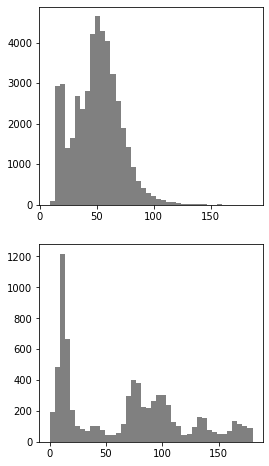

In [0]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))
ax1.hist(np.concatenate(distances_all), bins=40, color='gray')
#ax1.set_title('distances')
ax2.hist(np.concatenate(angles_all), bins=40, color='gray');
#ax2.set_title('angles');

Make an animation:

In [0]:
def create_anim_from_png(png_dir, moviename='anim', duration=1,
                         savedir='./', remove_dir=True):
    """Create animation from saved png files"""
    import imageio, shutil
    images = []
    for file_name in sorted(os.listdir(png_dir),
                            key=lambda fname: int(fname.split('.')[0])):
        if file_name.endswith('.png'):
            images.append(imageio.imread(os.path.join(png_dir, file_name)))
    imageio.mimsave(os.path.join(savedir, moviename + '.gif'), images)
    if remove_dir:
        shutil.rmtree(png_dir)

def save_frames(descr, png_dir):
    """Save separate "frames" as png files"""
    if not os.path.exists(png_dir):
        os.makedirs(png_dir) 
    fig, ax = plt.subplots(1, 1)
    for i, d in zip(frame_id, descr):
        ax.cla() # clean previous (if any) plot
        ax.hist(d, bins=40, color='gray')
        ax.set_title('Frame {}'.format(i))
        fig.savefig(os.path.join(png_dir, '{}.png'.format(i)))
    plt.close(fig)

Save frames

In [0]:
save_frames(distances_all, 'distances_anim')
save_frames(angles_all, 'angles_anim')

Create animation

In [0]:
create_anim_from_png('distances_anim', 'distances_anim_')
create_anim_from_png('angles_anim', 'angles_anim_')

We also analyze geometrical properties of all the nearest neighbor pairs. 

First define some helper functions.

In [0]:
def get_ellipse_axes(cnt_spl):
    """Returns coordinates and norm of
    minor and major axes of ellipse"""
    com_spl = np.mean(cnt_spl, axis=0)
    distances = [np.linalg.norm(c - com_spl) for c in cnt_spl]
    saxis_i, laxis_i = np.argmin(distances), np.argmax(distances)
    cnt_nrml = np.concatenate(
        (cnt_spl[saxis_i][None, ...], com_spl[None, ...]),
        axis=0)
    cnt_MA = np.concatenate(
        (cnt_spl[laxis_i][None, ...], com_spl[None, ...]),
        axis=0)
    return (cnt_nrml, distances[saxis_i],
            cnt_MA, distances[laxis_i])

def interp_spline(coord, s=15):
    """Contour interpolation"""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        tck, u = interpolate.splprep(coord, s=s, per=True)
        xs, ys = interpolate.splev(np.linspace(0, 1.0, 200), tck)
    return np.array([xs, ys]).T

def get_contours(imgdata):
    """Extracts contours from image data 
    (image data must be binary thresholded)"""
    assert int(cv2.__version__[0]) >= 4, "Use OpenCV version 4 or above"
    imgdata_ = cv2.convertScaleAbs(imgdata)
    contours = cv2.findContours(
        imgdata_.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
    return contours

def get_angle(x, y):
    "Angle between two vectors"
    ba = x[1, :] - x[0, :]
    bc = y[1, :] - y[0, :]
    enum = np.dot(ba, bc)
    denom = np.linalg.norm(ba) * np.linalg.norm(bc)
    return np.arccos(enum/denom) * 180 / np.pi

Run the analysis:

In [0]:
# arrange frames in image stack
frames_all = [f['decoded'][None, ...] for f in trajectories.values()]
frames_all = np.concatenate(frames_all, axis=0)

start_with = 10 # start frame (it might make sense to skip very first frames)

# Frame 3, 95, 111, 144, 181, 390, 394, 505, 513, 557 result in
# RuntimeWarning: invalid value encountered in double_scalars
# Need to look closer at what is wrong with these particular frames

a1, a2, descriptors = [], [], []
# Iterate over frames
for i, frame in enumerate(frames_all[start_with:]):
    print('\r', '{} / {}'.format(i+1, len(frames_all[start_with:])), end="")
    # get contours for one frame
    contours = get_contours(frame)
    # get COM of all contours (after interpolating) in this frame
    com_spl_all = [np.mean(interp_spline(c[:,0,:].T), axis=0)[None, ...] 
                   for c in contours]
    com_spl_all = np.concatenate((com_spl_all), axis=0)
    # iterate over the extracted contours
    cnt_used = []
    for i, cnt in enumerate(contours):
        # get geometric characteristic of individual contour
        cnt_spl = interp_spline(cnt[:,0,:].T)
        sax, sax_norm, lax, lax_norm = get_ellipse_axes(cnt_spl)
        # find the contour's nearest neighbor and distance to it
        nn_dist, nn_idx = spatial.cKDTree(com_spl_all).query(
            np.mean(cnt_spl, axis=0), 2)
        nn_dist, nn_idx = nn_dist[-1], nn_idx[-1]
        if [nn_idx, i] in cnt_used:
            continue
        # get geometric characteristics of this nearest neighbor contour
        cnt_nn = contours[nn_idx]
        cnt_nn_spl = interp_spline(cnt_nn[:,0,:].T)
        sax_nn, sax_nn_norm, lax_nn, lax_nn_norm = get_ellipse_axes(cnt_nn_spl)
        # calculate angles and projection
        # angle between radius vector and normal
        r_ij = np.concatenate((
            np.mean(cnt_spl, axis=0)[None,:], 
            np.mean(cnt_nn_spl, axis=0)[None,:]),
            axis=0)
        angle = get_angle(r_ij, sax_nn)
        # angle between particle's long axis and image axis
        l = np.argsort(lax[:,1]) # make sure the definition of vector direction is consistent for all particles
        lax = lax[l,:]
        imaxis = np.concatenate(
            (lax[0:1], lax[0:1] + np.array([1., 0.])),
            axis=0)
        angle_imaxis = (get_angle(lax, imaxis) + 90) % 180 # shift to match the opencv implementation
        # angle between particles
        l = np.argsort(lax_nn[:,1])
        lax_nn = lax_nn[l,:]
        angle_nn = get_angle(lax, lax_nn)
        # calculate projection of radius vector onto the normal
        proj = abs(np.cos(np.deg2rad(angle))* nn_dist)
        proj_normalized = proj / (sax_norm + sax_nn_norm)
        # store results
        if not any([np.isnan(angle).any(), np.isnan(proj_normalized).any()]):
            a1.append(angle)
            a2.append(proj_normalized)
            descriptors.append(np.array(
                [sax_norm, lax_norm, sax_nn_norm, lax_nn_norm, nn_dist,
                 angle_imaxis, angle_nn])[None, ...])
            # store indices of these two contours so that not to count them twice
            cnt_used.append([i, nn_idx])
# list to ndarray (easier to plot and manipulate)
descriptors = np.concatenate(descriptors, axis=0)

 593 / 593

Plot statistics:

<Figure size 576x576 with 0 Axes>

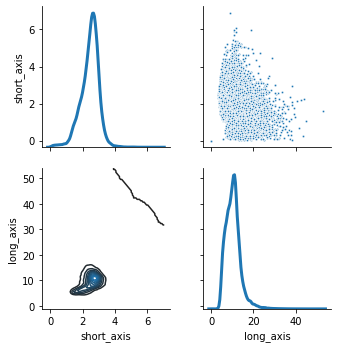

<Figure size 576x576 with 0 Axes>

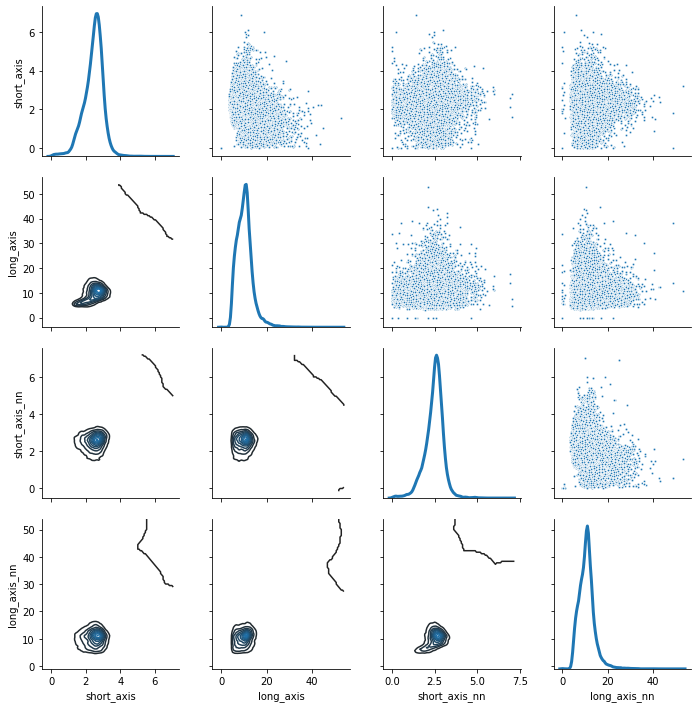

<Figure size 576x576 with 0 Axes>

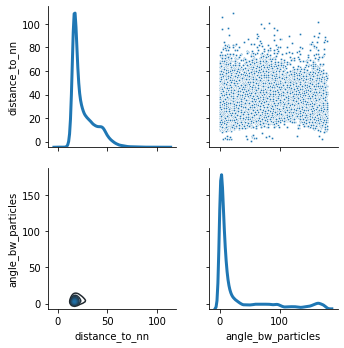

In [0]:
# Here we give names to descriptors, which are understandable to reader
descriptors_list = ['short_axis', 'long_axis', 'short_axis_nn', 'long_axis_nn',
                    'distance_to_nn', 'angle_w_imaxis', 'angle_bw_particles']
assert len(descriptors_list) == descriptors.shape[-1],\
"the number of element in the list must be equal to the number of features"

# Specify descriptors for joint plot(s)
descriptors_to_plot = ['short_axis', 'long_axis']

cols = pd.DataFrame(descriptors, columns=descriptors_list)
plt.figure(figsize=(8, 8))
g = sns.PairGrid(cols, diag_sharey=False, vars=descriptors_to_plot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot, s=7)
g.map_diag(sns.kdeplot, lw=3)

# Specify descriptors for joint plot(s)
descriptors_to_plot = ['short_axis', 'long_axis', 'short_axis_nn','long_axis_nn' ]

cols = pd.DataFrame(descriptors, columns=descriptors_list)
plt.figure(figsize=(8, 8))
g = sns.PairGrid(cols, diag_sharey=False, vars=descriptors_to_plot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot, s=7)
g.map_diag(sns.kdeplot, lw=3)

# Specify descriptors for joint plot(s)
descriptors_to_plot = ['distance_to_nn', 'angle_bw_particles']

cols = pd.DataFrame(descriptors, columns=descriptors_list)
plt.figure(figsize=(8, 8))
g = sns.PairGrid(cols, diag_sharey=False, vars=descriptors_to_plot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot, s=7)
g.map_diag(sns.kdeplot, lw=3)

In [0]:
# Pairwise plot with controlled range
b1 = 'short_axis'
b2 = 'long_axis'

col_num1 = [i for i, j in enumerate(descriptors_list) if j == b1][0]
col_num2 = [i for i, j in enumerate(descriptors_list) if j == b2][0]
b1 = descriptors[:, col_num1]
b2 = descriptors[:, col_num2]

h = sns.jointplot(b1, b2, kind="kde", ylim = (0,10), space=0, color="g")
h.set_axis_labels('Angle', 'Normalized distance', fontsize=16)
plt.tight_layout()

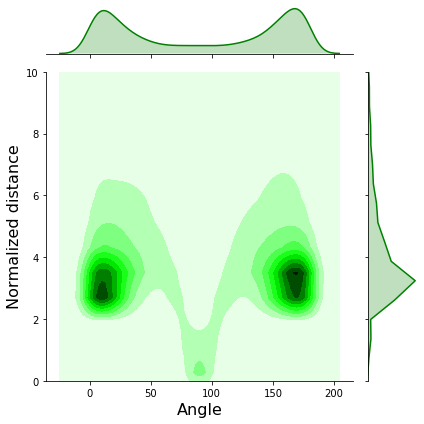

In [0]:
# There are a few strange values in a2 - let's get rid of them
idx_to_del = np.where(np.array(a2)>256)[0]
a1 = np.delete(a1, idx_to_del)
a2 = np.delete(a2, idx_to_del)

h = sns.jointplot(a1, a2, kind="kde", ylim = (0,10), space=0, color="g")
h.set_axis_labels('Angle', 'Normalized distance', fontsize=16)
plt.tight_layout()



position of maxima: [176.39910832198757, 3.1437695096800398]


Text(0, 0.5, 'Normalized distance')

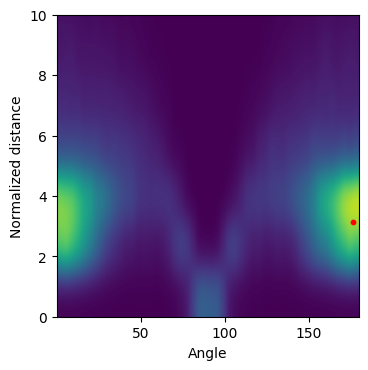

In [0]:
# get bi-dimensional histogram of samples
n_ = np.histogram2d(a1, a2, bins=50)[0]

# find position of maxima
max_val = np.where(n_==np.max(n_))
max_val_x = float(max_val[0] * (np.ptp(a1) / n_.shape[0]))
max_val_y = float(max_val[1] * (np.ptp(a2) / n_.shape[1]))
print('position of maxima: [{}, {}]'.format(max_val_x, max_val_y))

# plot results
_, ax = plt.subplots(1, 1, dpi=100)
ax.imshow(n_.T, origin='top', 
          extent=(np.min(a1), np.max(a1), np.min(a2), np.max(a2)),
          interpolation='Gaussian')
ax.set_ylim(0, 10)
ax.scatter(max_val_x, max_val_y, c='red', s=10)
ax.set_aspect(18)
ax.set_xlabel('Angle')
ax.set_ylabel('Normalized distance')

## Decomposition analysis on movie frames

Get an image stack:

In [0]:
frames_all = [f['decoded'][None, ...] for f in trajectories.values()]
frames_all = np.concatenate(frames_all, axis=0)

For each image in a stack, we calculate 2D FFT and correlation function.

In [0]:
def fft_(img):
    """Calculates fft of image"""
    F = np.fft.fft2(img)
    F_shift = np.fft.fftshift(F)
    return np.abs(F_shift)

frames_all_fft = np.zeros(shape=frames_all.shape)
for i in range(frames_all.shape[0]):
    print('\r', '{} / {}'.format(i+1, frames_all.shape[0]), end="")
    frames_all_fft[i, :, :] = fft_(frames_all[i,:,:])

 603 / 603

We now perform PCA/NMF decomposition on the constructed image stacks:

In [0]:
# Select number of components
nc = 2
# Select the dataset
X_vec = frames_all_fft.copy()
X_vec = (X_vec - np.min(X_vec)) / np.max(X_vec)
# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'NMF'
# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
dim1, dim2, dim3 = X_vec.shape
X_vec_t = clf.fit_transform(X_vec.reshape(dim1, dim2*dim3))
components = clf.components_
components = components.reshape(nc, dim2, dim3)
print(components.shape, X_vec_t.shape)

(2, 512, 512) (603, 2)


Plot results:

NUMBER OF COMPONENTS: 2
Components...


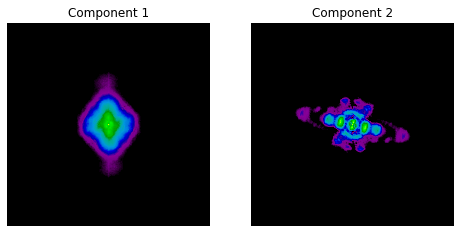

Evolution in time


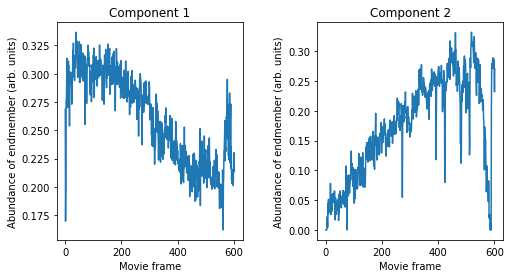

In [0]:
from matplotlib.colors import LogNorm

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    _ = ax1.imshow(components[i], cmap='nipy_spectral',
                   norm=LogNorm(vmin=0.01, vmax=1.0), # played with log norm contrast
                   Interpolation='Gaussian')
    ax1.set_title('Component ' + str(i + 1))
    ax1.set_axis_off()
plt.show()
print('Evolution in time')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize=(4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    j = 0
    ax2.plot(X_vec_t[:, i])
    ax2.set_xlabel("Movie frame")
    ax2.set_ylabel("Abundance of endmember (arb. units)")
    ax2.set_title('Component ' + str(i + 1))
plt.subplots_adjust(wspace=0.4)
plt.show()


We next calculate a radial distribution function for each frame.

In [0]:
def rdf2d(x, y, side, rmax, dr=0.5):
    """Standard implementation of the 2d pair correlation function"""
    
    condx1, condx2 = x > rmax, x < (side - rmax)
    condy1, condy2 = y > rmax, y < (side - rmax)
    interior_indices = np.where(condx1 * condx2 * condy1 * condy2)[0]
    num_interior_particles = interior_indices.shape[0]

    edges = np.arange(0., rmax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = np.zeros([num_interior_particles, num_increments])
    radii = np.zeros(num_increments)
    numberDensity = len(x) / side**2
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = np.sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * rmax

        (result, bins) = np.histogram(d, bins=edges, density=False)
        g[p, :] = result/numberDensity

    g_average = np.zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        r_outer = edges[i + 1]
        r_inner = edges[i]
        g_average[i] = np.mean(g[:, i]) / (np.pi * (r_outer**2 - r_inner**2))

    return g_average

In [0]:
start_frame = 10 # start frame (inclusion of the very first frames lead to some artifacts (investigating...))
end_frame = len(trajectories) # end frame
box_size = 512 # frame size

# Run analysis
rdf_all_frames = []
for k in range(start_frame, end_frame):
    #print('\r', '{} / {}'.format(k-start_frame+1, end_frame-start_frame), end="")
    coord = trajectories[k]['coordinates']
    y, x = coord.T
    rdf_i = rdf2d(x, y, box_size, box_size/10)
    rdf_all_frames.append(rdf_i[None, :])
rdf_all_frames = np.concatenate(rdf_all_frames, axis=0)

Run the decomposition analysis:

In [0]:
# Select number of components
nc = 2
# Select the dataset
X_vec = rdf_all_frames.copy()
X_vec = (X_vec - np.min(X_vec)) / np.max(X_vec)
# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'NMF'
# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
print(components.shape, X_vec_t.shape)

(2, 103) (593, 2)


Plot the results:

NUMBER OF COMPONENTS: 2
Components...


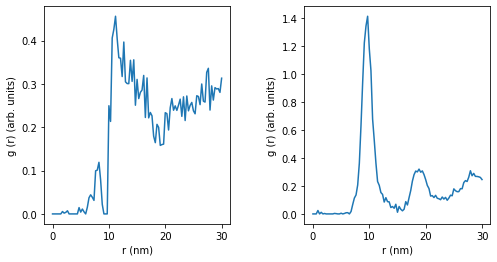

Evolution in time


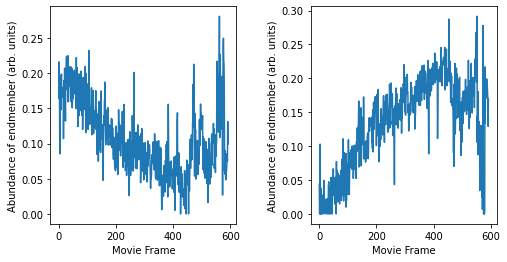

In [0]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    _ = ax1.plot(np.linspace(0, 30, len(components[1-i])), components[1-i])
    ax1.set_xlabel("r (nm)")
    ax1.set_ylabel("g (r) (arb. units)")
    #ax1.set_title('Component ' + str(i + 1))
plt.subplots_adjust(wspace=0.4)
plt.show()
print('Evolution in time')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize=(4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    j = 0
    ax2.plot(X_vec_t[:, 1-i])
    ax2.set_xlabel("Movie Frame")
    ax2.set_ylabel("Abundance of endmember (arb. units)")
    #ax2.set_title('Component ' + str(i + 1))
plt.subplots_adjust(wspace=0.4)
plt.show()

## Clustering/unmixing + transition frequency analysis on subimages

Create a stack of subimages. Each submimage is centered around an individual particle.

In [0]:
# crop half-size
crs = 32
img_cr_all, frame_num, coord_all  = [], [], []
# iterate over frames
for k, val in trajectories.items():
    print('\r', '{} / {}'.format(k+1, len(trajectories.keys())), end="")
    frame = val['decoded']
    coord = val['coordinates']
    # iterate over particles in the selected frame 
    for c in coord:
        # crop image of a selected size around particle's center
        img_cr = frame[int(np.around(c[1])-crs) : int(np.around(c[1])+crs),
                       int(np.around(c[0])-crs) : int(np.around(c[0])+crs)]
        # add to list
        if img_cr.shape == (2*crs, 2*crs):
            img_cr_all.append(img_cr[None, ...])  
            frame_num.append(k)
            coord_all.append(coord)
# list to stack            
img_cr_all = np.concatenate(img_cr_all, axis=0)         

 603 / 603

Reshape data for clustering/decomposition analysis:

In [0]:
e1, e2, e3 = img_cr_all.shape
X_vec = img_cr_all.reshape(e1, e2*e3)
X_vec.shape

(57818, 4096)

First explore the data with PCA:

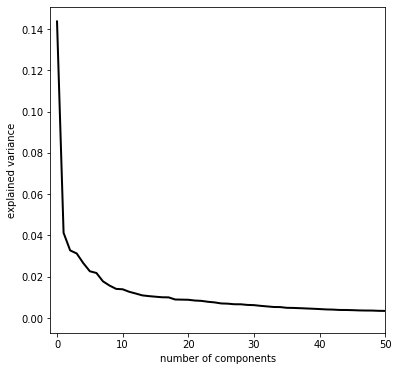

In [0]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 6))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c='black')
plt.axis('tight')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xlim(-1, 50);

Below we are going to use GMM for finding different classes/structures in the stack of extracted sub-images.



In [0]:
!pip install -q atomai

In [0]:
import atomai as aoi

Convert data format to the format compatible with AtomAI:

In [0]:
class_coord_dict = {}
for k in range(len(trajectories)):
    coord_all = trajectories[k]['coordinates']
    coord_all = np.concatenate((coord_all[:,1:2], coord_all[:,0:1]), axis=1)
    coord_all = np.concatenate(
        (coord_all, np.zeros(len(coord_all))[:, None]), axis=-1) # the class needs to be specified even when there is only one class
    class_coord_dict[k] = coord_all

decoded_all = [f['decoded'][None, ..., None] for f in trajectories.values()] # channel must be explicitly specified
decoded_all = np.concatenate(decoded_all, axis=0)

Form 'local descriptors' object:

In [0]:
imstack = aoi.atomstat.imlocal(decoded_all, class_coord_dict, crop_size=32, coord_class=0)

Perform GMM analysis. This may take several minutes

(note: GMM analysis is done automatically when calculating transition matrix, so in principle this step can be skipped):


GMM components


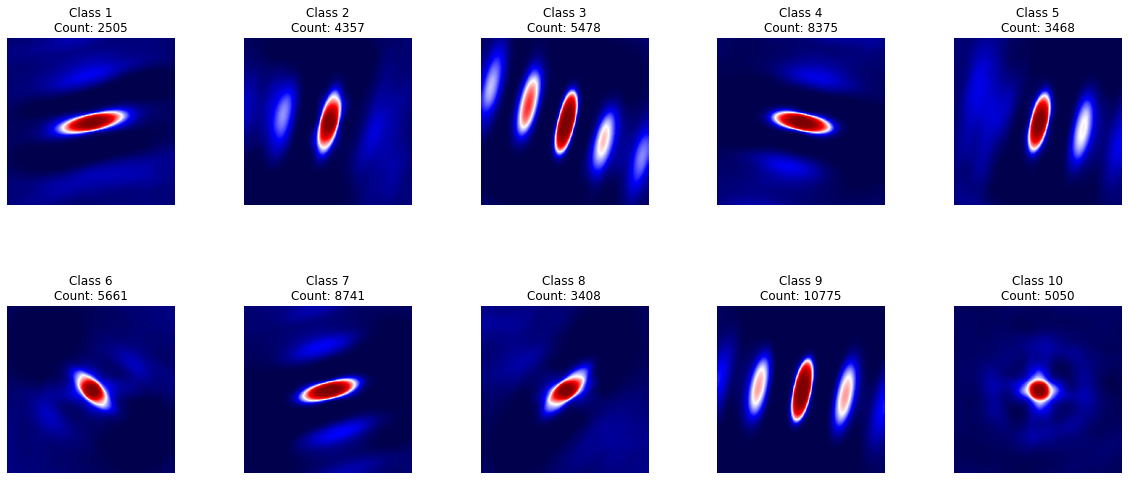

In [0]:
gmm_components = imstack.gmm(n_components=10, random_state=8000, plot_results=True)

Calculate trajectories via k-d tree search and the associated transition probabilities between different GMM classes. This may take 5-10 minutes.

In [0]:
n_comp = 10 # number of GMM components
rmax = 16 # distance cut-off for KDTree-based trajectory search
min_length = 20 # minimum number of observations for a trajectory to be included

trans_dict = imstack.transition_matrix(
    n_components=n_comp, rmax=rmax, min_length=min_length, random_state=8000)

View results (trajectory + transition matrix + classes with highest transition frequencies) for selected trajectories:

(note that sometimes we can have a class that has a single transition into only one other class - this will lead to a weird result of having probability "1" in the associated row. This of course doesn't make sense since, to put it mildly, there is no statistically significant amount of events in this case)

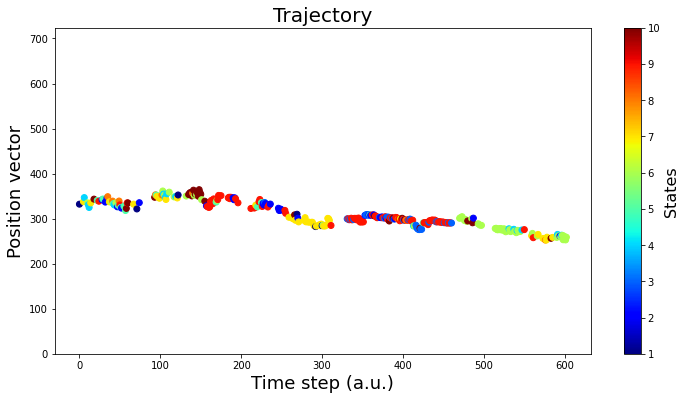

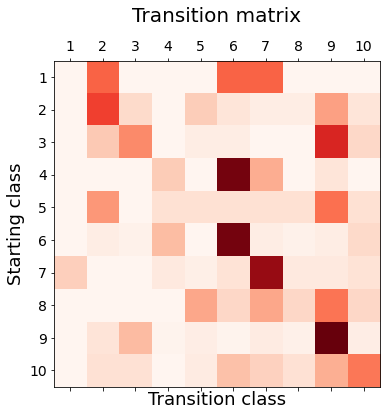


Starting class  --->  Transition class (Prob: 0.625)


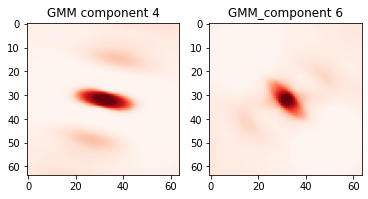

Starting class  --->  Transition class (Prob: 0.45161290322580644)


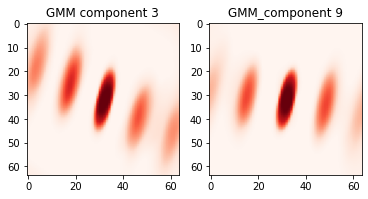

Starting class  --->  Transition class (Prob: 0.3333333333333333)


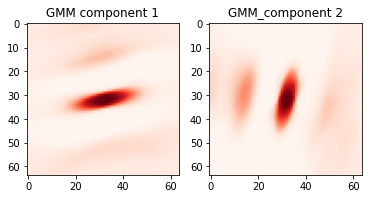

Starting class  --->  Transition class (Prob: 0.3333333333333333)


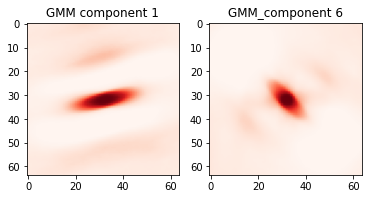

Starting class  --->  Transition class (Prob: 0.3333333333333333)


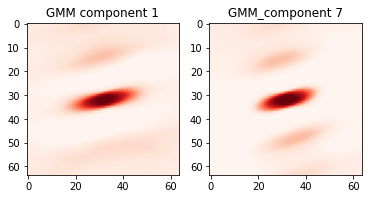

In [0]:
fov = [512, 512] # field of view (scan size)
k = 12 # trajectory to visualise

aoi.utils.plot_trajectories_transitions(trans_dict, k, fov=fov, plot_toself=False)

Sum (and normalize) all the transitions:

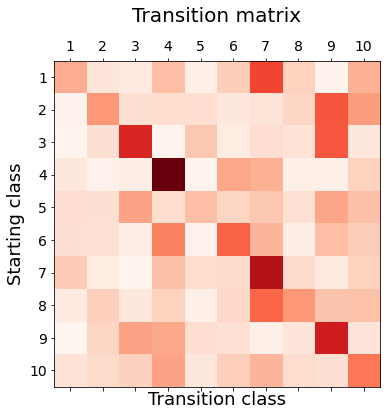


Starting class  --->  Transition class (Prob: 0.29890275823247964)


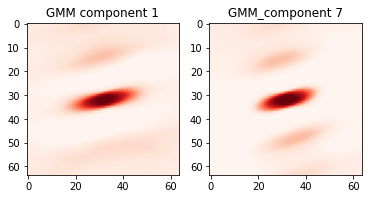

Starting class  --->  Transition class (Prob: 0.277476319398624)


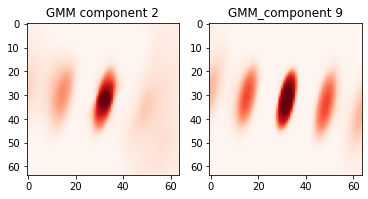

Starting class  --->  Transition class (Prob: 0.2755286220443514)


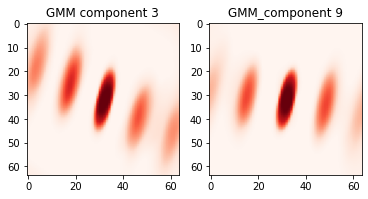

Starting class  --->  Transition class (Prob: 0.2560339939857904)


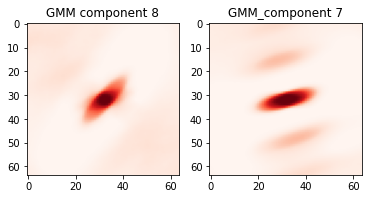

Starting class  --->  Transition class (Prob: 0.21247277101261458)


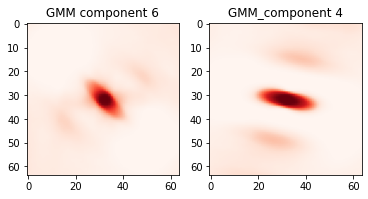

Starting class  --->  Transition class (Prob: 0.1714112765279338)


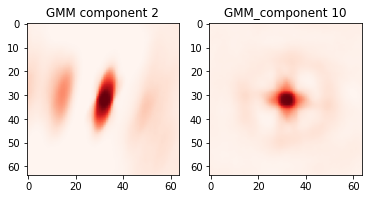

In [0]:
transmat_all = aoi.atomstat.sum_transitions(trans_dict, n_comp, plot_results=True, transitions_to_plot=7, plot_toself=False)